In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

## Configs

In [3]:
torch.use_deterministic_algorithms(True)

## Create datasets

In [4]:
train_data = CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)


test_data = CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

In [6]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## Show a few examples

In [7]:
def show_image(image, label, ax):
    image = image * 0.5 + 0.5
    np_image = image.numpy()
    transposed_np_image = np.transpose(np_image, (1, 2, 0))

    ax.imshow(transposed_np_image)
    (ax.set_title(f"{label}"),)

torch.Size([3, 32, 32])
tensor(1)


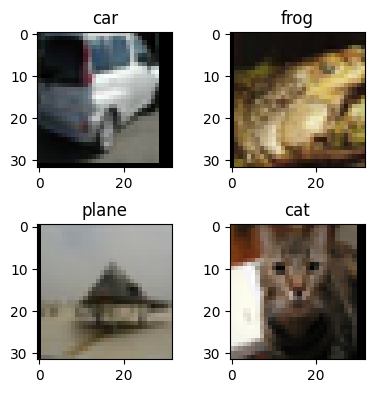

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4))

fig.tight_layout()
axs = axs.flatten()


train_data_iterator = iter(train_data_loader)
images, labels = next(train_data_iterator)

print(images[0].shape)
print(labels[0])

for i in range(4):
    show_image(images[i], classes[labels[i]], axs[i])
plt.show()

## Create train-test

In [15]:
def train(net, train_loader, optim, loss_fn, epoch):
    """Trains the given neural network model using the provided data loader, optimizer, and loss function for a specified number of epochs.

    Args:
        net: The neural network model to be trained.
        train_loader: The data loader containing the training dataset.
        optim: The optimizer used to update the model's parameters.
        loss_fn: The loss function used to compute the training loss.
        epoch: The current epoch number.
    """
    net.train()
    batch_loss = 0.0

    for batch_idx, (batch_X_train, batch_y_train) in enumerate(train_loader):
        optim.zero_grad()
        y_pred = net(batch_X_train)
        loss = loss_fn(y_pred, batch_y_train)
        loss.backward()
        optim.step()
        batch_loss += loss.item()
        if (batch_idx + 1) % 1000 == 0:
            print(f"[Epoch number : {epoch + 1}, Mini-batches: {batch_idx + 1}, Loss: {batch_loss / 1000}]")

            batch_loss = 0.0

In [16]:
def test(net, test_loader):
    """Calculates the accuracy of the LeNet model on the test dataset.

    Args:
        net: The LeNet model.
        test_loader: The data loader for the test dataset.
    """
    net.eval()
    success = 0
    counter = 0
    with torch.no_grad():
        for (X_test, y_test) in test_loader:
            y_pred = net(X_test)
            _, pred = torch.max(y_pred.data, 1)
            counter += y_test.size(0)
            success += (pred == y_test).sum().item()
    print("LeNet accuracy on 10000 images from test dataset: %d %%" % (100 * success / counter))

## Create LeNet-5

In [ ]:
class LeNet(nn.Module):
    """ "LeNet-5

    LeNet-5 is a convolutional neural network architecture that consists of two sets of convolutional and average pooling
    layers , followed by three fully connected layers. The input to the network is a 3x32x32 image and the output is a
    10-dimensional vector representing the class probabilities.
    """

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)  # 3x32x32 -> 6x28x28
        x = F.relu(x)  # 6x28x28
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  # 6x28x28 -> 6x14x14
        x = self.conv2(x)  # 6x14x14 -> 16x10x10
        x = F.relu(x)  # 16x10x10
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  # 6x10x10 -> 16x5x5
        x = self.flatten(x)  # 16x5x5 -> 400
        x = self.fc1(x)  # 400 -> 120
        x = F.relu(x)  # 120
        x = self.fc2(x)  # 120 -> 84
        x = F.relu(x)  #
        x = self.fc3(x)  # 84 -> 10

        return x

## Train-test model

In [17]:
lenet = LeNet()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)


for epoch in range(50):
    train(lenet, train_data_loader, optim, loss_fn, epoch)
    print()
    test(lenet, test_data_loader)
    print()
print("Finished Training")

[Epoch number : 1, Mini-batches: 1000, Loss: 1.9910785140991212]
[Epoch number : 1, Mini-batches: 2000, Loss: 1.7708351353406906]
[Epoch number : 1, Mini-batches: 3000, Loss: 1.6991750336289406]
[Epoch number : 1, Mini-batches: 4000, Loss: 1.6353608554005623]
[Epoch number : 1, Mini-batches: 5000, Loss: 1.6015805570483208]
[Epoch number : 1, Mini-batches: 6000, Loss: 1.5725669294595719]

LeNet accuracy on 10000 images from test dataset: 43 %

[Epoch number : 2, Mini-batches: 1000, Loss: 1.5069671021103859]
[Epoch number : 2, Mini-batches: 2000, Loss: 1.5248159408867359]
[Epoch number : 2, Mini-batches: 3000, Loss: 1.498839440345764]
[Epoch number : 2, Mini-batches: 4000, Loss: 1.4630525279045106]
[Epoch number : 2, Mini-batches: 5000, Loss: 1.4821997048258782]
[Epoch number : 2, Mini-batches: 6000, Loss: 1.4345283633172512]

LeNet accuracy on 10000 images from test dataset: 48 %

[Epoch number : 3, Mini-batches: 1000, Loss: 1.4241949374973775]
[Epoch number : 3, Mini-batches: 2000, Los

In [18]:
model_path = "models/lenet.pth"
torch.save(lenet.state_dict(), model_path)

In [23]:
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path, weights_only=False))


<All keys matched successfully>

In [35]:
d_iter = iter(test_data_loader)
X_test, y_test = next(d_iter)
y_pred = lenet_cached(X_test)
class_pred = torch.argmax(y_pred, dim=1)

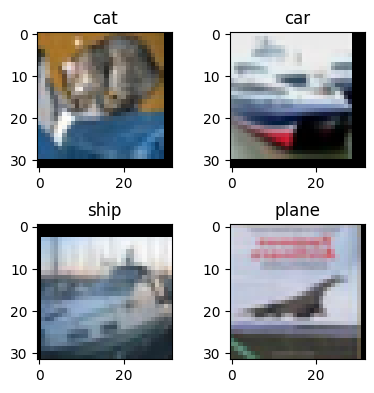

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4))

fig.tight_layout()
axs = axs.flatten()

for i in range(4):
    show_image(X_test[i], classes[class_pred[i]], axs[i])
plt.show()

In [39]:
class_pred

tensor([3, 1, 8,  ..., 5, 1, 7])

In [41]:
y_test

tensor([3, 8, 8,  ..., 5, 1, 7])

In [57]:
overall_accuracy = torch.mean((class_pred == y_test).float(), dim=0).item() * 100

print(f"Overall accuracy: {overall_accuracy:.2f}%")

Overall accuracy: 64.34%


In [47]:
classe

tensor([ True, False,  True,  ...,  True,  True,  True])

In [78]:
for i in range(10):
    mask = y_test == i
    accuracy = (class_pred[mask] == i).float().mean().item() * 100
    print(f"Accuracy for class {classes[i]}: {accuracy:.2f}%")

Accuracy for class plane: 63.50%
Accuracy for class car: 82.70%
Accuracy for class bird: 52.50%
Accuracy for class cat: 31.20%
Accuracy for class deer: 55.00%
Accuracy for class dog: 67.20%
Accuracy for class frog: 75.00%
Accuracy for class horse: 72.90%
Accuracy for class ship: 73.80%
Accuracy for class truck: 69.60%


In [73]:
class_pred == 11

tensor([False, False, False,  ..., False, False, False])

In [77]:
torch.unique(y_test)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])